In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
from IPython.display import clear_output
import gym
import matplotlib.pyplot as plt

In [3]:
class DQN_Agent:
  def __init__(self, input_shape, n_actions):
    self.rng = 1
    self.rng_min = 0.1
    self.rng_decay = 0.995
    self.discount = 0.95
    self.weights='weights'
    self.decay_ctr = 0
    self.transfer_weight_ctr = 0

    self.memory = deque(maxlen=20_000)

    self.input_shape = input_shape
    self.n_actions = n_actions
    self.model = self.create_model()
    self.target_model = self.create_model()
    self.transfer_weights()

  def create_model(self):
    input = Input(shape=(128,))
    x = Dense(512, activation='relu')(input)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    V = Dense(1, activation='linear')(x)
    A = Dense(self.n_actions, activation='linear')(x)
    Q = V + tf.subtract(A, tf.reduce_mean(A, axis=1, keepdims=True))
    #output = Dense(self.n_actions, activation='linear')(x)
    
    model = Model(inputs=input, outputs=Q)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

  def remember(self, state, action, reward, state_, done):
    self.memory.append([state, action, reward, state_, done])

  def save(self):
    self.model.save_weights(self.weights)

  def load(self):
    self.model.load_weights(self.weights)
    self.transfer_weights()

  def action(self, state):
    if random.random() < self.rng:
      return random.randint(0, self.n_actions - 1)
    else:
      return np.argmax(self.predict(state))

  def predict(self, state):
    return self.model.predict(np.reshape(state, (1, self.input_shape)))

  def train(self):
    if len(self.memory) < 5_000:
      return

    self.decay_ctr += 1
    self.transfer_weight_ctr += 1

    mini_batch = random.sample(self.memory, 32)
    states = np.array([memory[0] for memory in mini_batch])
    states_ = np.array([memory[3] for memory in mini_batch])
    qs = self.model.predict(states)
    qs_ = self.target_model.predict(states_)

    X = states
    y = []

    for i, memory in enumerate(mini_batch):
      action = memory[1]
      reward = memory[2]
      done = memory[4]

      if done:
        q = reward
      else:
        q = reward + self.discount * np.max(qs_[i])

      qs[i][action] = q
      y.append(qs)
    
    self.model.fit(X, np.array(y), verbose=0, shuffle=False)

    if self.decay_ctr > 10:
      self.decay_rng()
      self.decay_ctr = 0

    if self.transfer_weight_ctr > 50:
      self.transfer_weights()
      self.transfer_weight_ctr = 0

  def decay_rng(self):
    self.rng = self.rng * self.rng_decay
    if self.rng < self.rng_min:
      self.rng = self.rng_min

  def transfer_weights(self):
    self.target_model.set_weights(self.model.get_weights())

In [4]:
env = gym.make('Breakout-ram-v0')

In [5]:
agent = DQN_Agent(128, env.action_space.n)
score_record = []

In [6]:
agent.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          66048       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
______________________________________________________________________________________________

In [9]:
episodes = 500
for episode in range(1, (episodes + 1)):
  state = env.reset()
  done = False
  score = 0
  train_step = 0
  while not done:
    env.render()
    action = agent.action(state)
    state_, reward, done, info = env.step(action)
    score += reward
    
    train_step += 1

    reward = (reward * 10) + 1
    
    if done:
      reward = -20
    
    agent.remember(state, action, reward, state_, done)
    if train_step > 15:
        agent.train()
        train_step = 0

    if done:
      clear_output(wait=True)
      print(f'Episode: {episode}\nScore: {score}\nAgent RNG: {agent.rng}')
      score_record.append(score)

    state = state_
env.close()

Episode: 389
Score: 1.0
Agent RNG: 0.1


KeyboardInterrupt: 

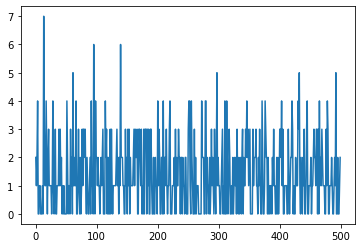

In [7]:
plt.plot(score_record)

In [8]:
def save_score():
  fh = open('score.txt', 'a')
  fh.write(score)
  fh.close()